# Get Dataset

In [ ]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
!unzip DSL2122_january_dataset.zip

# Import required libraries

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Preview of Dataset

In [ ]:
dataframe = pd.read_csv('/content/DSL2122_january_dataset/development.csv')
dataframe

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...,...
224989,0,2261324310,Sat Jun 20 20:36:48 PDT 2009,NO_QUERY,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,1989408152,Mon Jun 01 01:25:45 PDT 2009,NO_QUERY,unitechy,Trying the qwerty keypad
224991,0,1991221316,Mon Jun 01 06:38:10 PDT 2009,NO_QUERY,Xaan,I love Jasper &amp; Jackson but that wig in th...
224992,0,2239702807,Fri Jun 19 08:51:56 PDT 2009,NO_QUERY,Ginger_Billie,I am really tired and bored and bleh! I feel c...


# Analyzing Dataset

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


We need only Sentiment and Text

In [ ]:
""" Some Examples """

print(dataframe['text'][63])
# In this case one word is Binary(At least it is not english)

print(dataframe['text'][51])
# In this case we have @id + website

print(dataframe['text'][149])
# In this case word [-O] is not a word 


""" So many cases exist in the dataset like cases above and needs to be cleaned """

@Md8oz that hurt  ã?³ just fucked me harddddd lol
@HOTTVampChick here you go  http://bit.ly/qNtRH
[-O] Just got off work getting ready to leave for INDPLS 500 mini-marathon. Wish me luck.  http://tinyurl.com/cnn45k


' So many cases exist in the dataset like cases above and needs to be cleaned '

In [ ]:
texts = dataframe['text']
new_texts = []
for i in range(len(texts)):
  list_of_words = texts[i].split()
  list_of_noise = ['@','http',':','&','^','$','www']
  tmp = []
  for word in list_of_words[:]:
    if len(word) > 1 :
      has_noise = False
      for noise in list_of_noise:
        if noise in word:
          has_noise = True
          break
      if has_noise == False:
        tmp.append(word)
  new_tweet = " ".join(tmp)
  new_texts.append(new_tweet)

print(len(texts))
print(len(new_texts))

224994
224994


In [ ]:
sentiments = dataframe['sentiment']

maxLen = 0
for text in new_texts:
  if len(text) > maxLen:
    maxLen = len(text)

print("Max lenght of a tweet has ",maxLen," words")

Max lenght of a tweet has  356  words


In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(new_texts)
sequences = tokenizer.texts_to_sequences(new_texts)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=maxLen)
Y = np.array(sentiments)

# Split Train and Validation

In [ ]:
train_x , val_x, train_y ,val_y = train_test_split(X,Y,test_size = .15,stratify=Y)

print('train : ',train_x.shape , train_y.shape)
print('val : ',val_x.shape,val_y.shape)

train :  (191244, 356) (191244,)
val :  (33750, 356) (33750,)


# Use F1 accuracy as medric

In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Building our Model

In [ ]:
embedding_dim = 32
input = keras.Input(shape=(maxLen))
embedding_layer = keras.layers.Embedding(len(word_index) + 1,embedding_dim)
embedded = embedding_layer(input)
lstm = keras.layers.LSTM(256,dropout = 0.2)(embedded)
dense = keras.layers.Dense(512,activation = 'relu')(lstm)
dropout = keras.layers.Dropout(0.2)(dense)
dense = keras.layers.Dense(64,activation = 'relu')(dropout)
output = keras.layers.Dense(1,activation = 'sigmoid')(dense)

model = keras.Model(input,output)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4),loss = 'binary_crossentropy',metrics=['acc',f1_m])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 356)]             0         
                                                                 
 embedding (Embedding)       (None, 356, 32)           2663072   
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65    

In [ ]:
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr = 1e-6,verbose = 1)
checkpoint_callback = keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss',mode='min',verbose=1, save_best_only=True,save_weights_only=True)
checkpoint_callback_f1 = keras.callbacks.ModelCheckpoint('model_f1.h5', monitor='val_f1_m',mode='max',verbose=1, save_best_only=True,save_weights_only=True)


history = model.fit(x = train_x,y= train_y,batch_size = 8,epochs = 10,validation_data = (val_x,val_y),validation_batch_size = 12,callbacks = [reduce_lr,checkpoint_callback,checkpoint_callback_f1])

Epoch 1/10
23906/23906 [==============================] - ETA: 0s - loss: 0.4844 - acc: 0.7629 - f1_m: 0.7811
Epoch 00001: val_loss improved from inf to 0.44265, saving model to model.h5

Epoch 00001: val_f1_m improved from -inf to 0.80983, saving model to model_f1.h5
23906/23906 [==============================] - 2176s 91ms/step - loss: 0.4844 - acc: 0.7629 - f1_m: 0.7811 - val_loss: 0.4426 - val_acc: 0.7928 - val_f1_m: 0.8098 - lr: 1.0000e-04
Epoch 2/10
23906/23906 [==============================] - ETA: 0s - loss: 0.4353 - acc: 0.7955 - f1_m: 0.8053
Epoch 00002: val_loss improved from 0.44265 to 0.43232, saving model to model.h5

Epoch 00002: val_f1_m did not improve from 0.80983
23906/23906 [==============================] - 2144s 90ms/step - loss: 0.4353 - acc: 0.7955 - f1_m: 0.8053 - val_loss: 0.4323 - val_acc: 0.7971 - val_f1_m: 0.8095 - lr: 1.0000e-04
Epoch 3/10
23906/23906 [==============================] - ETA: 0s - loss: 0.4195 - acc: 0.8042 - f1_m: 0.8132
Epoch 00003: val_l

In [ ]:
!cp /content/model.h5 /content/drive/MyDrive

# Plot training

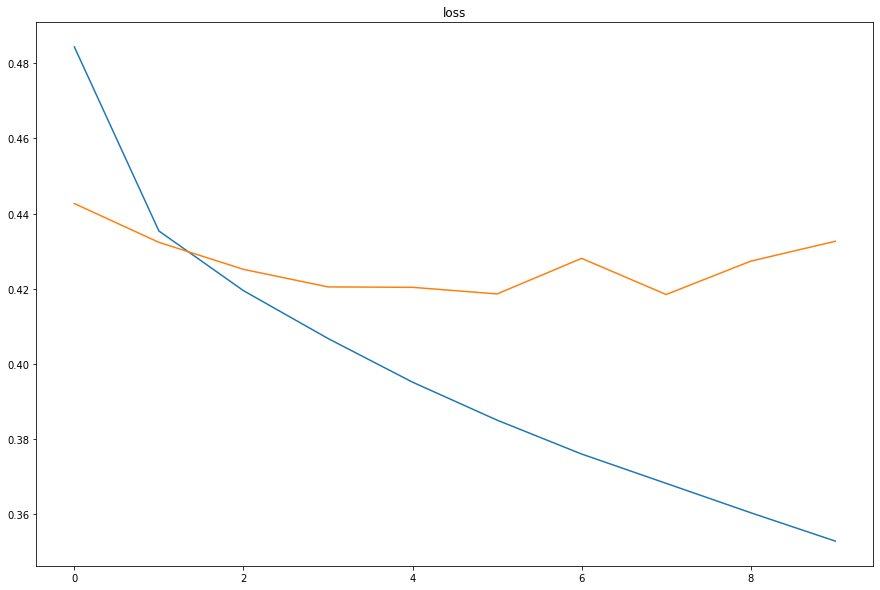

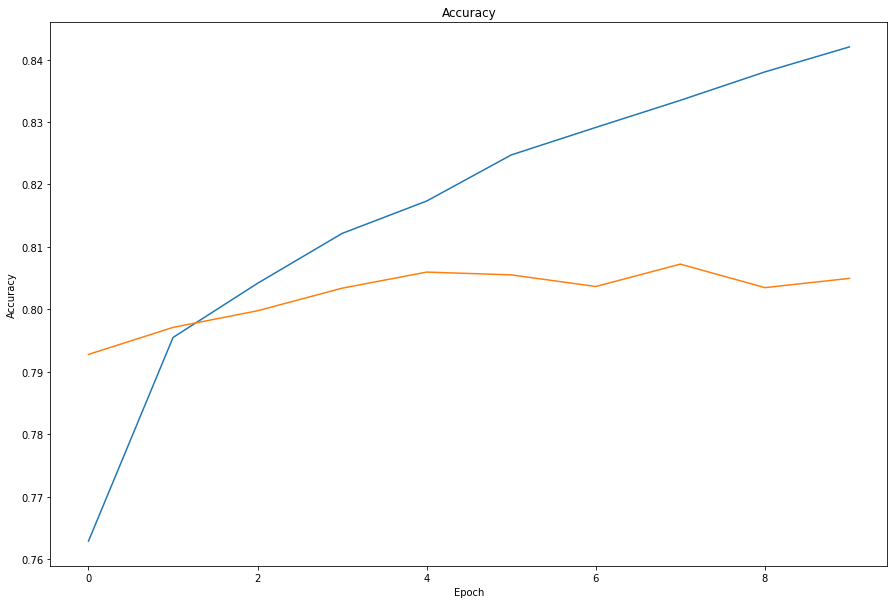

In [ ]:
def plot_acc(history, title = 'Accuracy'):
    plt.figure(figsize=(15,10))
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    if title is not None:
        plt.title(title)

    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

def plot_loss(history, title = 'loss'):
    plt.figure(figsize=(15,10))
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)

plot_loss(history)
plot_acc(history)

# Evaluate Model

In [ ]:
model.load_weights('model_f1.h5')
predictions = model.predict(val_x)
target_names = ['Negative', 'Positive']
print(classification_report(val_y, np.where(predictions>0.5,1,0), target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.78      0.76      0.77     14226
    Positive       0.83      0.84      0.83     19524

    accuracy                           0.81     33750
   macro avg       0.80      0.80      0.80     33750
weighted avg       0.81      0.81      0.81     33750



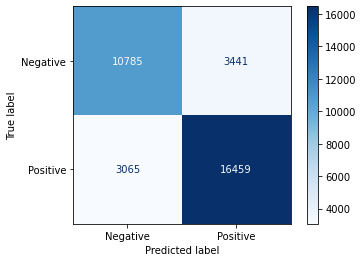

In [ ]:
cm = confusion_matrix(y_true = val_y,y_pred = np.where(predictions>0.5,1,0), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(cmap = "Blues")

# Test on Evaluation DataSet 

In [ ]:
test_dataframe = pd.read_csv('/content/DSL2122_january_dataset/evaluation.csv')
texts = test_dataframe['text']

maxLen_test = 0
for text in texts:
  if len(text) > maxLen_test:
    maxLen_test = len(text)

print(maxLen_test)

new_texts = []
for i in range(len(texts)):
  list_of_words = texts[i].split()
  list_of_noise = ['@','http',':','&','^','$','www']
  tmp = []
  for word in list_of_words[:]:
    if len(word) > 1 :
      has_noise = False
      for noise in list_of_noise:
        if noise in word:
          has_noise = True
          break
      if has_noise == False:
        tmp.append(word)
  new_tweet = " ".join(tmp)
  new_texts.append(new_tweet)

print(len(new_texts))

sequences = tokenizer.texts_to_sequences(new_texts)
X = pad_sequences(sequences, maxlen=maxLen)

model.load_weights('model.h5')
p = model.predict(X)
p = np.where(p>0.5,1,0)

In [ ]:
submission_csv = pd.read_csv('/content/DSL2122_january_dataset/sample_submission.csv')

submission_csv['Predicted'] = p
submission_csv.to_csv('submission.csv',index =False)